# **Detect and Classify Tremor from the IRIS Database**
---
Workflow:
- Imports
- Inputs
- Define Functions
- Define Detect and Classify Function
- Bin by Days
- Apply Function & Process in Parallel 
- Concat Results & Save

## Imports

In [1]:
import datetime
from obspy.clients.fdsn.client import Client
import obspy
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import dask
from dask.diagnostics import ProgressBar

#client = Client('IRIS')
import pickle
import os
import scipy.signal
import scipy.ndimage

from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import trigger_onset
from obspy import UTCDateTime
from obspy import Stream

from pnwstore.mseed import WaveformClient
from obspy import Stream
from datetime import timedelta


from obspy.clients.fdsn import Client
from datetime import timedelta, datetime

import logging
logging.basicConfig(level=logging.INFO)

print('done')

done


In [2]:
# gets data locally rather than online
client = WaveformClient()

## Inputs
Short Term Average & Long Term Average (STA/LTA) parameters

In [3]:
# Define step we want to chunk
step = 10 # seconds

# Define sta and lta window lengths
# Below chosen to optimize emergent signal detection!

sta_win = 10 # seconds, short term window
lta_win = 1000 # seconds, long term window

Time Endpoints and Station

In [4]:
t1 = obspy.UTCDateTime("2017-09-01T00:00:00.000")
t2 = obspy.UTCDateTime("2017-09-08T00:00:00.000")

network = 'OO'
station = 'HYSB1' #be careful with adding more stations because they'll have to be cycled through in the code
channel = 'HHN'

## Define Functions
- Detect/Triggering: Check Data, Calculate STL/STA
- Classify: Pick Peaks, Apply Gaussian, Ship Noise
- Attach Response Cascadia
- Waveform across Midnight

Check Data

In [5]:
def check_data(stream,t1,sr,step,data_time_length):
    
    data = stream[0].data
    data_sample_length = sr * data_time_length

    
    # Catch for if data stream is less than specified
    if len(data) < data_sample_length:
        data_sample_length = int(len(data) - (len(data)%(sr*step)))
        data_time_length = int(data_sample_length / sr)
        
    # Catch for if start time is not as specified
    if stream[0].stats.starttime != t1:
        t1 = stream[0].stats.starttime
    
    return(t1,data_time_length)

Calculate Short Term Average & Long Term Average (STL/STA)

In [6]:
def calc_stalta(data,sr,step,data_time_length,sta_win,lta_win):
    
    # Matricize the data as step s chunks
    data_sample_length = sr * data_time_length
    
    
    chunked = np.reshape(data[0:data_sample_length],[int(data_sample_length/(sr*step)),int(sr*step)])
    chunked_medians = [np.median(chunked[i,:]) for i in range(np.shape(chunked)[0])]
    chunked_times = np.linspace(0,data_time_length,len(chunked_medians))
    
    # Step through and calculate sta & lta every step s
    sta = []
    lta = []
    for i,vec in enumerate(chunked_medians):

        # STA is median of the next window
        nwin = int(sta_win / step)
        sta.append(np.median(chunked_medians[i:i+nwin]))


        # LTA is median of the past window
        nwin = int(lta_win / step)
        lta.append(np.median(chunked_medians[i-nwin:i]))
    
    stalta = np.array(sta)/np.array(lta)
    
    return(stalta,chunked_times)

Pick Peaks

In [7]:
def pick_peaks_welch(trace,sampling_rate,nperseg_multiple,microseism_cutoff=True):
    """
    Estimate power spectra of a trace using Welch's method
    Pick peaks within the spectra!
    
    INPUTS:
    trace = obspy object, waveform
    sampling_rate = sampling rate of trace
    nperseg_multiple = length of each segment used to construct the Welch spectrum
    microseism_cutoff = Bool, whether or not to cut off the lower end of the spectrum to avoid the microseism
    
    OUTPUTS:
    f = frequencies of the spectra
    Pxx_den = associated power at each frequency, in decibels
    peak_ind = index of peaks within the spectra (f and Pxx_den), if found
    peaks = picked peak object from scipy
    median_power = median power of spectra from 20-80 Hz in decibels
    """
    
    
    fs = sampling_rate
    x = trace.data
    nperseg = fs * nperseg_multiple
    
    f,Pxx_den = scipy.signal.welch(x,fs,nperseg=nperseg)
    if microseism_cutoff is True:
        f = f[4:]
        Pxx_den = Pxx_den[4:]
        
    Pxx_den = [10*np.log10(d) for d in Pxx_den]
    median_power = np.median(Pxx_den[20:80])
    
    peaks = scipy.signal.find_peaks(Pxx_den,threshold =median_power*5,prominence=10) 
    peak_ind = peaks[0]
    
    return(f,Pxx_den,peak_ind,peaks,median_power)

Apply Gaussian

In [8]:
def apply_gaussian(filtered_data,samp_rate,gaussian_width=5):
    """
    Smooth waveform using a gaussian window
    
    INPUTS
    filtered_data = filtered numpy array of seismic data (from an obspy trace)
    samp_rate = sampling rate of data
    gaussian width = width of Gaussian window in seconds
    
    OUTPUTS
    smoothed_window = smoothed numpy array of seismic data
    """
    
    # Square data
    data = filtered_data**2
    
    gaussian_radius = int((gaussian_width * samp_rate)/2)
    smoothed_window=scipy.ndimage.gaussian_filter1d(data,sigma=gaussian_radius/4,radius=gaussian_radius)
    
    return smoothed_window

Ship Noise

In [9]:
def ship_noise_classifier(trace,sampling_rate):
    """
    Check whether detection likely includes ship noise in the form of a spectral peak
    
    INPUTS
    trace = obspy trace object
    sampling_rate = sample rate of trace
    
    OUTPUTS
    ship_classifier = number of peaks in the spectra. If any exist, ship noise is likely!
    """
    
    
    # Pick peaks on the smoothed spectrum of the trace (nperseg multiple = 1)
    f,Pxx_den,peak_ind,peak_details,median_power = pick_peaks_welch(trace,sampling_rate,1,microseism_cutoff=True)
    
    if len(peak_ind)==0:
        ship_classifier = 0
    else:
        ship_classifier = len(peak_ind)

    
    return ship_classifier

In [10]:
def attach_response_cascadia(stream):
    """
    Reads in an obspy stream
    Pulls down station response information for the corresponding station from where it is stored in Cascadia
    Attaches this station response information to the stream, and returns the stream
    """
    
    # This is where station response information is stored on Cascadia, in xml format:
    dir_base = '/1-fnp/pnwstore1/p-wd11/PNWStationXML/'
    
    network = stream[0].stats.network
    station = stream[0].stats.station
    
    # Response file paths are in the format /1-fnp/pnwstore1/p-wd11/PNWStationXML/OO/OO.HYSB1.xml
    response_file = dir_base+network+'/'+network+'.'+station+'.xml'

    # Read response info using obspy
    inventory = obspy.read_inventory(response_file)

    # Attach response information to stream
    stream.attach_response(inventory)
    
    return stream

In [11]:
def get_waveform_across_midnight(client, network, station, location, channel, starttime, endtime):
    stream = Stream()
    current = starttime
    while current < endtime:
        end_of_day = obspy.UTCDateTime(current.date) + 86399  # 23:59:59
        chunk_end = min(end_of_day, endtime)
        #print(current, chunk_end)
        #try:
        st_chunk = client.get_waveforms(
            network=network, station=station,
            location=location, channel=channel,
            starttime=current, endtime=chunk_end,
        )
        sr = round(st_chunk[0].stats.sampling_rate)
        st_chunk.resample(sr).merge(fill_value="interpolate")
        stream += st_chunk
        #except Exception as e:
        #    print(f"Failed to get data from {current} to {chunk_end}: {e}")
        current = obspy.UTCDateTime(current.date + timedelta(days=1))
    return stream

## Define Detect and Classify Function

In [53]:
def trigger_and_classify(t1, data_time_length, network, station, channel, step, sta_win, lta_win, filepath):
    """
    Detects and classifies seismic events using STA/LTA and signal features.
    """

    # Adjust times with padding
    t1 = obspy.UTCDateTime(t1)
    t2 = t1 + data_time_length + 1000
    t1 = t1 - 1000

    #try:
    client = WaveformClient() 

    # === 1. Detection ===
    st1 = get_waveform_across_midnight(client, network, station, "*", channel, t1, t2)
    st1.merge(fill_value= "interpolate")
    #print(f"Stream length: {len(st1)}")
    if len(st1) == 0:
        print(f"[{t1}] No traces found in stream. Skipping.")
        return [], []

    sr = round(st1[0].stats.sampling_rate)
    if st1[0].stats.sampling_rate != sr:
        st1.resample(sr).merge(fill_value="interpolate")
    st1.taper(0.05, max_length=5)
    st1.filter("bandpass", freqmin=3, freqmax=10)
    st1.trim(starttime=t1, endtime=t2)

    t1, data_time_length = check_data(st1, t1, sr, step, data_time_length)
    data = np.abs(st1[0].data)
    #print(f"Analyzing {st1[0].stats.station} {st1[0].stats.channel}")
    stalta, times = calc_stalta(data, sr, step, data_time_length, sta_win, lta_win)
    triggers = trigger_onset(stalta, 2, 1)
    ontimes = [t1 + times[tr[0]] for tr in triggers]
    offtimes = [t1 + times[tr[1]] for tr in triggers] 
    # Get rid of any detections less than 30 s
    keep_ind = []
    for j in range(len(ontimes)):
        if offtimes[j]-ontimes[j] > 30:
            keep_ind.append(j)
    ontimes = [ontimes[j] for j in keep_ind]
    offtimes = [offtimes[j] for j in keep_ind]

    # === 2. Classification ===
    all_results = []

    for on, off in zip(ontimes, offtimes):
        #try:
        t1c, t2c = on, off
        print(t1c,t2c)

        # Ship noise classifier
        st_ship = get_waveform_across_midnight(client, network, station, "*", channel, t1c, t2c)
        st_ship.resample(sr).merge(fill_value="interpolate")
        st_ship = attach_response_cascadia(st_ship)
        st_ship[0].data = st_ship[0].data / st_ship[0].stats.response.instrument_sensitivity.value
        st_ship.trim(starttime=t1c, endtime=t2c)
        ship_classifier = ship_noise_classifier(st_ship[0], sr)

        # Waveform peak classifier
        st_wave = get_waveform_across_midnight(client, network, station, "*", channel, t1c, t2c)
        st_wave.resample(sr).merge(fill_value="interpolate")
        st_wave = attach_response_cascadia(st_wave)
        st_wave.filter("bandpass", freqmin=3, freqmax=10)
        st_wave.remove_response()
        st_wave.trim(starttime=t1c, endtime=t2c)
        print(st_wave)
        max_amplitude = np.max(np.abs(st_wave[0].data))
        smoothed = apply_gaussian(st_wave[0].data, sr, gaussian_width=15)
        smoothed = smoothed / np.max(smoothed)
        print(np.max(smoothed))
        peaks = scipy.signal.find_peaks(smoothed, prominence=0.1)
        print(peaks)
        num_waveform_peaks = len(peaks[0])
        print(num_waveform_peaks)

        # Welch frequency ratio
        t1w = t1c - 30
        t2w = t2c + 30
        st_welch = get_waveform_across_midnight(client, network, station, "*", channel, t1w, t2w)
        st_welch.resample(sr).merge(fill_value="interpolate")
        st_welch = attach_response_cascadia(st_welch)
        st_welch[0].data = st_welch[0].data / st_welch[0].stats.response.instrument_sensitivity.value
        st_welch.trim(starttime=t1w, endtime=t2w)
        f, Pxx_den, *_ = pick_peaks_welch(st_welch[0], sr, 5, microseism_cutoff=False)
        freq_ratio_welch = 10 ** (np.median(Pxx_den[25:50]) / 10) / 10 ** (np.median(Pxx_den[50:75]) / 10)

        # Save result
        all_results.append([
            (t1c, t2c), station, num_waveform_peaks,
            ship_classifier, freq_ratio_welch, max_amplitude
        ])

        #except Exception as e:
            #print(f"Classification failed for detection starting at {str(on)}: {e}")
            #continue

    # === Save all results ===
    # combined_file = filepath + station + "_all_detections.pickle"
    # with open(combined_file, "wb") as handle:
    #     pickle.dump(all_results, handle)

    return all_results

    #except Exception as e:
        #print(f"[{str(t1)}] No data or fatal error during detection/classification: {e}")
        #return [], []


2017-09-01T21:56:00.000000Z 2017-09-01T21:58:49.000000Z

In [54]:
test=trigger_and_classify(time_bins[0], data_time_length, network, station, channel, step, sta_win, lta_win, save_dir)

/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2017-09-01T04:32:32.008334Z 2017-09-01T04:34:12.019910Z
1 Trace(s) in Stream:
OO.HYSB1..HHN | 2017-09-01T04:32:32.010000Z - 2017-09-01T04:34:12.020000Z | 200.0 Hz, 20003 samples
1.0
(array([], dtype=int64), {'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)})
0
2017-09-01T21:56:19.256858Z 2017-09-01T21:58:49.274222Z
1 Trace(s) in Stream:
OO.HYSB1..HHN | 2017-09-01T21:56:19.255000Z - 2017-09-01T21:58:49.270000Z | 200.0 Hz, 30004 samples
1.0
(array([], dtype=int64), {'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64)})
0


## Bin data by days

In [13]:
time_bins = pd.date_range(start=t1.datetime, end=t2.datetime, freq='D')
data_time_length = 24 * 60 * 60
# Path to save classification results
save_dir = 'classifications/'
pickle_name = 'testing.pickle'

In [14]:
#st = get_waveform_across_midnight(client, network, station,'*', channel,obspy.UTCDateTime(time_bins[0]),obspy.UTCDateTime(time_bins[1]))

In [15]:
#results=trigger_and_classify(time_bins[2], data_time_length, network, station, channel, step, sta_win, lta_win,save_dir)


In [ ]:
test

## Apply function & Process in Parallel 

In [29]:
os.chdir("/home/lydiagk/obs_tremor/tremor_detection") # set directory
# Path to save classification results
save_dir = 'classifications/'
pickle_name = 'testing.pickle'

@dask.delayed
def loop_days(t, data_time_length, network, station, channel, step, sta_win, lta_win, filepath):
    t_utc = obspy.UTCDateTime(t)
    return trigger_and_classify(t_utc, data_time_length, network, station, channel, step, sta_win, lta_win, filepath)

# Build lazy results list
lazy_results = [
    loop_days(t, data_time_length, network, station, channel, step, sta_win, lta_win, save_dir)
    for t in time_bins
]

# Run Dask
with ProgressBar():
    results = dask.compute(*lazy_results)

[                                        ] | 0% Completed | 10.74 sms

/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[                                        ] | 0% Completed | 12.07 s

/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[                                        ] | 0% Completed | 17.32 s

/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[                                        ] | 0% Completed | 19.33 s

/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[                                        ] | 0% Completed | 20.12 s

/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[                                        ] | 0% Completed | 26.16 s

/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyter_share/miniconda3/envs/seismo2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[########################################] | 100% Completed | 145.47 s


## Concat Results and Save

In [30]:
with open(pickle_name, 'wb') as f:
    pickle.dump(results, f)

print(f"Saved combined detection results to {pickle_name}")
print(f"Total detections: {len(results)}")

Saved combined detection results to testing.pickle
Total detections: 8


## Checking my work by comparing to confirmed triggers

In [31]:
os.chdir("/home/lydiagk/obs_tremor/tremor_detection")


start_time = UTCDateTime("2017-09-01T00:00:00.000")
end_time = UTCDateTime("2017-09-08T00:00:00.000")


with open('testing.pickle', 'rb') as f:
    my_triggers = pickle.load(f)

# flatten the list 
flat_triggers = [detection for day in my_triggers for detection in day]
    
count = sum(1 for entry in flat_triggers if start_time <= entry[0][0] <= end_time)

print(f"Number of triggers between {start_time} and {end_time}: {count}")
starts = [entry[0][0] for entry in flat_triggers if start_time <= entry[0][0] <= end_time]
peaks = [entry[2] for entry in flat_triggers if start_time <= entry[0][0] <= end_time]
print(len(peaks))
print(peaks)

Number of triggers between 2017-09-01T00:00:00.000000Z and 2017-09-08T00:00:00.000000Z: 142
142
[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 4, 4, 4, 0, 2, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 15, 0, 0, 4, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 3, 2, 1, 7, 1, 1, 1, 2, 2, 3, 5, 1, 2, 1, 3, 2, 5, 0, 2, 1, 3, 1, 2, 3, 2, 3, 1, 2, 2, 9, 3, 3, 0, 11, 3, 2, 4, 2, 0, 1, 10, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 16]


In [66]:
os.chdir("/home/lydiagk/obs_tremor/tremor_detection/results")

# define time window
start_time_v = UTCDateTime("2017-09-01T00:00:00.000")
end_time_v = UTCDateTime("2017-09-08T00:00:00.000")

with open('HYSB1_HHN_3-10Hz_classifications.pickle', 'rb') as f:
    my_triggers_v = pickle.load(f)


count_v = sum(1 for entry in my_triggers_v if start_time_v <= entry[0][0] <= end_time_v)

print(f"Number of triggers between {start_time_v} and {end_time_v}: {count_v}")
starts_v = [entry[0][0] for entry in my_triggers_v if start_time_v <= entry[0][0] <= end_time_v]
peaks_v = [entry[2] for entry in my_triggers_v if start_time <= entry[0][0] <= end_time]

print(len(peaks_v))
print(peaks_v)

Number of triggers between 2017-09-01T00:00:00.000000Z and 2017-09-08T00:00:00.000000Z: 142
142
[4, 1, 2, 0, 2, 4, 1, 1, 2, 0, 3, 1, 5, 1, 1, 2, 1, 3, 3, 3, 1, 4, 2, 2, 4, 4, 3, 2, 2, 3, 2, 2, 0, 2, 1, 1, 2, 2, 3, 1, 1, 0, 34, 2, 3, 6, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 3, 5, 0, 3, 2, 5, 3, 5, 3, 1, 6, 3, 1, 4, 7, 8, 1, 4, 4, 2, 3, 2, 1, 7, 1, 1, 1, 2, 2, 3, 5, 1, 2, 1, 3, 1, 4, 0, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 9, 4, 7, 1, 11, 3, 2, 4, 2, 0, 1, 10, 4, 1, 1, 2, 2, 0, 0, 1, 1, 11, 3, 1, 2, 3, 1, 1, 1, 1, 1, 0, 1, 3, 1, 2, 16]


In [68]:
[entry for entry in my_triggers_v if start_time_v <= entry[0][0] <= end_time_v]

[[[2017-09-01T04:32:32.008334Z, 2017-09-01T04:34:12.019910Z],
  'HYSB1',
  4,
  2,
  2.898207383952851,
  1.7654704032983843e-07],
 [[2017-09-01T21:56:19.256858Z, 2017-09-01T21:58:49.274222Z],
  'HYSB1',
  1,
  1,
  1.2379523226376505,
  2.391519733055982e-07],
 [[2017-09-02T05:08:52.260678Z, 2017-09-02T05:10:22.271096Z],
  'HYSB1',
  2,
  0,
  2.233331375530439,
  3.940353903481946e-07],
 [[2017-09-02T05:31:12.415789Z, 2017-09-02T05:32:02.421577Z],
  'HYSB1',
  0,
  0,
  1.4542463572621094,
  2.004072456365942e-07],
 [[2017-09-02T14:26:06.130339Z, 2017-09-02T14:29:16.152332Z],
  'HYSB1',
  2,
  0,
  1.1925719995489976,
  2.987288307057966e-07],
 [[2017-09-02T14:33:06.178956Z, 2017-09-02T14:34:46.190531Z],
  'HYSB1',
  4,
  1,
  3.3436512404028607,
  2.6271667106464906e-07],
 [[2017-09-02T16:05:36.821391Z, 2017-09-02T16:06:26.827179Z],
  'HYSB1',
  1,
  1,
  2.6243761966604358,
  1.9796112991466435e-07],
 [[2017-09-02T17:56:57.594629Z, 2017-09-02T18:00:57.622410Z],
  'HYSB1',
  1,
  1,

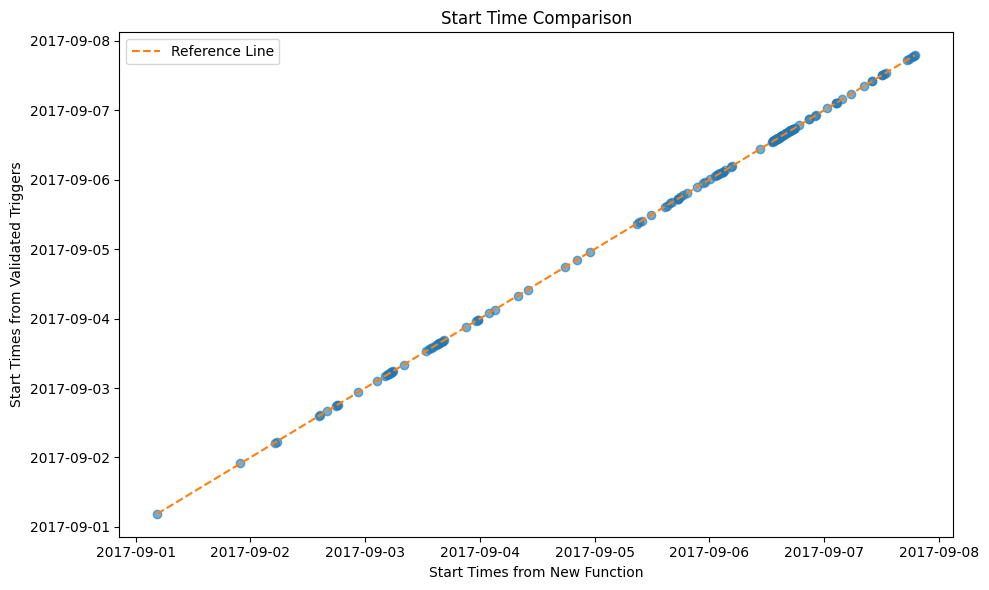

In [33]:

starts_dt = [t.datetime for t in starts if start_time <= t <= end_time]
starts_v_dt = [t.datetime for t in starts_v if start_time <= t <= end_time]

plt.figure(figsize=(10, 6))

plt.plot(starts_dt, starts_v_dt, 'o', alpha=0.6)
plt.plot(starts_dt, starts_dt, '--', label= "Reference Line")  

plt.xlabel("Start Times from New Function")
plt.ylabel("Start Times from Validated Triggers")
plt.title("Start Time Comparison")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

# From classified detections (flat_triggers)
start_classified = [entry[0][0].datetime for entry in flat_triggers if start_time <= entry[0][0] <= end_time]
duration_classified = [(entry[0][1] - entry[0][0]) for entry in flat_triggers if start_time <= entry[0][0] <= end_time]

# From validated detections (my_triggers_v)
start_validated = [entry[0][0].datetime for entry in my_triggers_v if start_time <= entry[0][0] <= end_time]
duration_validated = [(entry[0][1] - entry[0][0]) for entry in my_triggers_v if start_time <= entry[0][0] <= end_time]

plt.figure(figsize=(10, 4))

# new function results
plt.scatter(start_classified, duration_classified, label="New Function", alpha=0.8, c= 'blue')

# validated results
plt.scatter(start_validated, duration_validated, label="Validated Results", alpha=0.5, c = 'yellow')

plt.xlabel("Detection Start Time")
plt.ylabel("Detection Duration (seconds)")
plt.title("Start Time vs Duration Comparison")
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
# where the mismatch

start_time = UTCDateTime("2017-09-01T00:00:00.000")
end_time = UTCDateTime("2017-09-08T00:00:00.000")

# 1 peak and in window 
starts_classified = [entry[0][0].datetime for entry in flat_triggers
                     if entry[2] == 1 and start_time <= entry[0][0] <= end_time]

ends_classified = [entry[0][1].datetime for entry in flat_triggers
                     if entry[2] == 1 and start_time <= entry[0][0] <= end_time]

starts_validated = [entry[0][0].datetime for entry in my_triggers_v
                    if entry[2] == 1 and start_time <= entry[0][0] <= end_time]

ends_validated = [entry[0][1].datetime for entry in my_triggers_v
                    if entry[2] == 1 and start_time <= entry[0][0] <= end_time]


set_classified = set([dt.replace(microsecond=0) for dt in starts_classified])
set_validated  = set([dt.replace(microsecond=0) for dt in starts_validated])

set_classified_e = set([dt.replace(microsecond=0) for dt in ends_classified])
set_validated_e  = set([dt.replace(microsecond=0) for dt in ends_validated])


missed_in_classified = sorted(list(set_validated - set_classified))    # in validated but missing from new function
extra_in_classified  = sorted(list(set_classified - set_validated))    # in new function but not in validated

missed_in_classified_e = sorted(list(set_validated_e - set_classified_e))    # in validated but missing from new function
extra_in_classified_e  = sorted(list(set_classified_e - set_validated_e))

print("Missed by new function:")
for t in missed_in_classified:
    print(t)

print("\nExtra in new function:")
for t in extra_in_classified:
    print(t)
    
print("Missed by new function (ends):")
for t in missed_in_classified_e:
    print(t)

print("\nExtra in new function (ends):")
for t in extra_in_classified_e:
    print(t)
    
print(ends_classified)
print(ends_validated)

Missed by new function:
2017-09-01 21:56:19
2017-09-02 16:05:36
2017-09-03 02:23:31
2017-09-03 04:32:02
2017-09-03 04:42:32
2017-09-03 05:21:22
2017-09-03 05:48:22
2017-09-03 23:17:09
2017-09-04 07:55:23
2017-09-05 09:18:53
2017-09-05 11:47:15
2017-09-05 17:23:27
2017-09-05 17:26:47
2017-09-06 01:37:00
2017-09-06 02:23:11
2017-09-06 04:31:42
2017-09-06 14:22:36
2017-09-06 16:02:56
2017-09-06 16:50:47
2017-09-06 18:49:47
2017-09-07 00:41:20
2017-09-07 02:23:51
2017-09-07 03:45:41
2017-09-07 10:01:14
2017-09-07 10:02:34
2017-09-07 12:01:05
2017-09-07 12:10:15
2017-09-07 12:33:25
2017-09-07 18:27:47

Extra in new function:
2017-09-02 14:26:06
Missed by new function (ends):
2017-09-01 21:58:49
2017-09-02 16:06:26
2017-09-03 02:24:31
2017-09-03 04:32:52
2017-09-03 04:43:22
2017-09-03 05:21:52
2017-09-03 05:49:22
2017-09-03 23:18:49
2017-09-04 07:56:13
2017-09-05 09:19:44
2017-09-05 11:47:45
2017-09-05 17:24:37
2017-09-05 17:27:47
2017-09-06 01:37:30
2017-09-06 02:23:51
2017-09-06 04:32:12
2

In [75]:

# one mismatched time
start = UTCDateTime("2017-09-01T21:56:19")
end = UTCDateTime("2017-09-01T21:58:49")

# Get waveform
st1 = get_waveform_across_midnight(client, network, station, "*", channel, start, end)
st1.merge(fill_value= "interpolate")
sr = round(st1[0].stats.sampling_rate)
st_wave = get_waveform_across_midnight(client, network, station, "*", channel, start, end)
st_wave.resample(sr).merge(fill_value='interpolate')
st_wave = attach_response_cascadia(st_wave)
st_wave.filter("bandpass", freqmin=3, freqmax=10)
st_wave.remove_response()
st_wave.trim(starttime=start, endtime=end)

# smooth
raw = st_wave[0].data
smoothed = apply_gaussian(raw, sr, gaussian_width=15)
smoothed = smoothed / np.max(smoothed)

peaks, _ = scipy.signal.find_peaks(smoothed, prominence=0.1)
st1 = st_wave

In [58]:
print(start,end)
print(np.max(smoothed))
print(peaks) [[2017-09-01T21:56:19.256858Z, 2017-09-01T21:58:49.274222Z],
  'HYSB1',
  1,
  1,
  1.2379523226376505,
  2.391519733055982e-07],

2017-09-01T21:56:19.000000Z 2017-09-01T21:58:49.000000Z
1.0
[]


In [63]:
# one mismatched time
start = UTCDateTime("2017-09-01T21:56:19")
end = UTCDateTime("2017-09-01T21:58:49")

In [64]:
# Get waveform
client = Client('IRIS')
st_wave = client.get_waveforms(network, station, "*", channel,start, end,attach_response=True)
print(1)
sr = round(st_wave[0].stats.sampling_rate)
st_wave.resample(sr).merge(fill_value='interpolate')
print(2)
st_wave.filter("bandpass", freqmin=3, freqmax=10)
st_wave.remove_response()
st_wave.trim(starttime=start, endtime=end)

# smooth
raw = st_wave[0].data
smoothed = apply_gaussian(raw, sr, gaussian_width=15)
smoothed = smoothed / np.max(smoothed)

peaks, _ = scipy.signal.find_peaks(smoothed, prominence=0.1)

st2 = st_wave

1
2


In [41]:
st1[0].data

array([ 2.67034309e-11, -2.48741179e-10, -1.52298493e-09, ...,
       -5.91634725e-11,  2.85606156e-11, -3.04198115e-11])

In [42]:
st2[0].data

array([ 2.67503271e-11, -2.48008013e-10, -1.51923583e-09, ...,
       -5.75893062e-11,  2.75936547e-11, -2.96579202e-11])

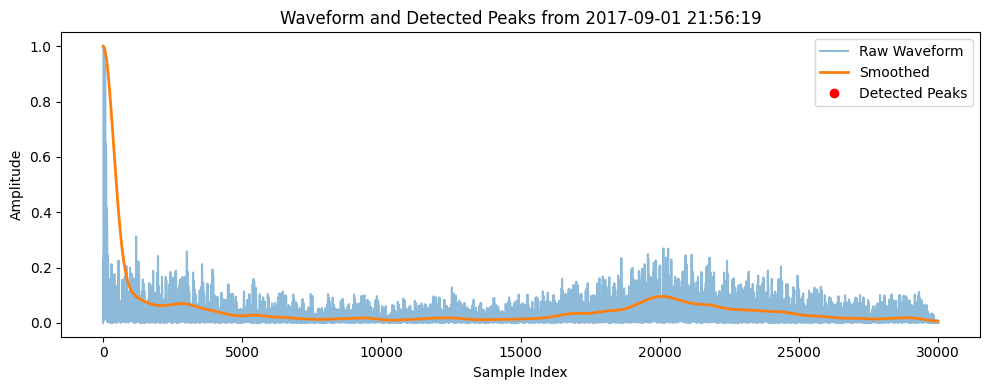

In [74]:
# plot
plt.figure(figsize=(10, 4))
plt.plot(raw/np.max(raw), label="Raw Waveform", alpha=0.5)
plt.plot(smoothed, label="Smoothed", linewidth=2)
plt.plot(peaks, smoothed[peaks], "ro", label="Detected Peaks")

plt.title(f"Waveform and Detected Peaks from {start.datetime}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

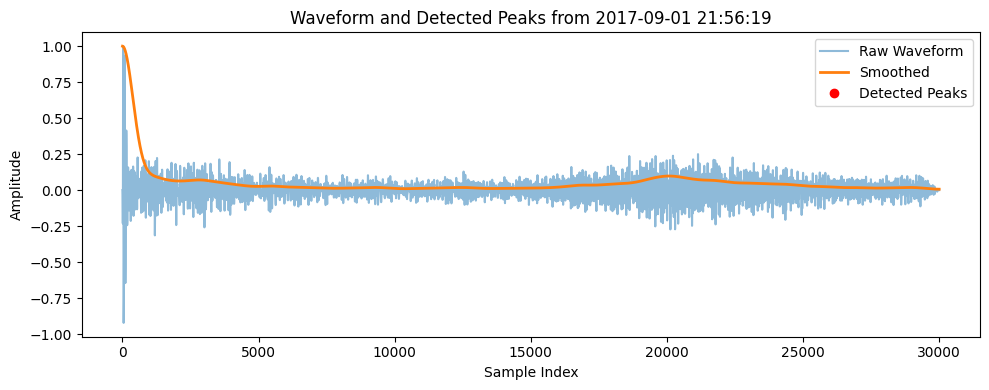

In [65]:
# plot
plt.figure(figsize=(10, 4))
plt.plot(raw/np.max(raw), label="Raw Waveform", alpha=0.5)
plt.plot(smoothed, label="Smoothed", linewidth=2)
plt.plot(peaks, smoothed[peaks], "ro", label="Detected Peaks")

plt.title(f"Waveform and Detected Peaks from {start.datetime}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()
